# VOYAGER DATA

Aiming to reproduce a particularly messy structure function in FraternaleEA (2019):

- Have pretty much reproduced the structure functions from the inner heliosheath (V1, 2011), at least at a reduced frequency due to computation time
- In order to be able to apply the correction factor, I need a standardised interval. This will be a subsection of the full SF of that figure
- I also need the LINT version

But I might also want to do it for the LISM, which has even higher % missing data. This regime only has power spectra rather than SFs in this paper, but this is fine, as we can compute equivalent spectra and compare it then. However, I will not be able to quickly reproduce Frat's spectra as they use their suite of spectra estimation methods, so I will need to scrape the data.


In [42]:
import numpy as np
import pandas as pd
import cdflib
import math as m
import pprint

# import seaborn as sns
import importlib
from scipy import signal
from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import gridspec
import matplotlib.dates as mdates

# while ".toplevel" not in os.listdir():
#     os.chdir("..")

from src.data_import_funcs import read_cdfs, date_1d_dict, read_asc_ts
import src.utils as utils
import src.params as params
import src.sf_funcs as sf

# Set matplotlib font size
plt.rc("text", usetex=True)
plt.rc("font", family="serif", serif="Computer Modern", size=20)


# Fraternale et al. (2019)

Using adapted function from Tulasi to read in multiple CDFs at once into a dictionary

In [2]:
voyager1_data_raw = read_cdfs(
    [
        # "data/raw/voyager/voyager1_48s_mag-vim_20090101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20100101_v01.cdf",
        "data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20120101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20130101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20140101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20150101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20160101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20170101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20180101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20190101_v01.cdf",
    ],
    ["Epoch", "F1", "BR", "BT", "BN"],
)

reading file  data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf
Done reading data


Converting dictionary into dated dataframe

In [3]:
voyager1_data = date_1d_dict(
    voyager1_data_raw, "48S"
)  # Resampling with freq means we do not get lines drawn between missing data points on line plots, however it does require some averaging which puts the time points slightly off
# voyager2_data = date_1d_dict(voyager2_data_raw, "48S")
# voyager1_data['mag_calculated'] = (voyager1_data['BR']**2 + voyager1_data['BT']**2 + voyager1_data['BN']**2)**(1/2)
# voyager1_data[voyager1_data.mag_calculated < 0.03] = np.nan
# print(voyager1_data.mag_calculated.min())
len(voyager1_data)
# len(voyager2_data)

Here is a snippet of the raw data (before re-sampling according to freq)
                              F1       BR       BT       BN
Time                                                       
2011-01-01 12:37:31.584  0.21758  0.06866  0.15611  0.13507
2011-01-01 12:38:19.968  0.22162  0.06511  0.15956  0.13923
2011-01-01 12:39:08.352  0.21891  0.06550  0.15134  0.14371
2011-01-01 12:39:55.872  0.21616  0.06289  0.15407  0.13775
2011-01-01 12:40:44.255  0.21758  0.06584  0.15295  0.14001


654641

In [4]:
def convert_angle(x):
    if x < 0:
        x += 360
    return x


voyager1_data["lambda"] = (
    voyager1_data["BT"]
    .div(voyager1_data["BR"])
    .apply(m.atan)
    .apply(m.degrees)
    .apply(convert_angle)
)
voyager1_data["delta"] = (
    voyager1_data["BN"].div(voyager1_data["F1"]).apply(m.asin).apply(m.degrees)
)

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>], dtype=object)

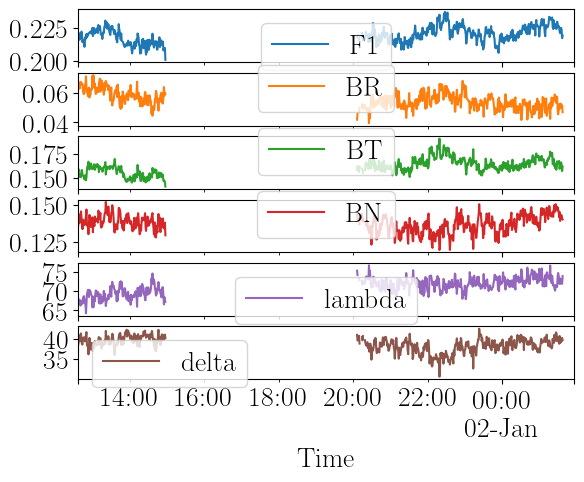

In [5]:
voyager1_data[:1000].plot(subplots=True)

In [6]:
# Proportion of missing data
print(voyager1_data.isna().sum() / len(voyager1_data["F1"]))

F1        0.694581
BR        0.694581
BT        0.694581
BN        0.694581
lambda    0.694581
delta     0.694581
dtype: float64


Re-creating Fraternale 2019 Fig. 1(a)

In [7]:
# Resample to daily cadence
voyager1_data_daily = voyager1_data.resample("D").mean()

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>], dtype=object)

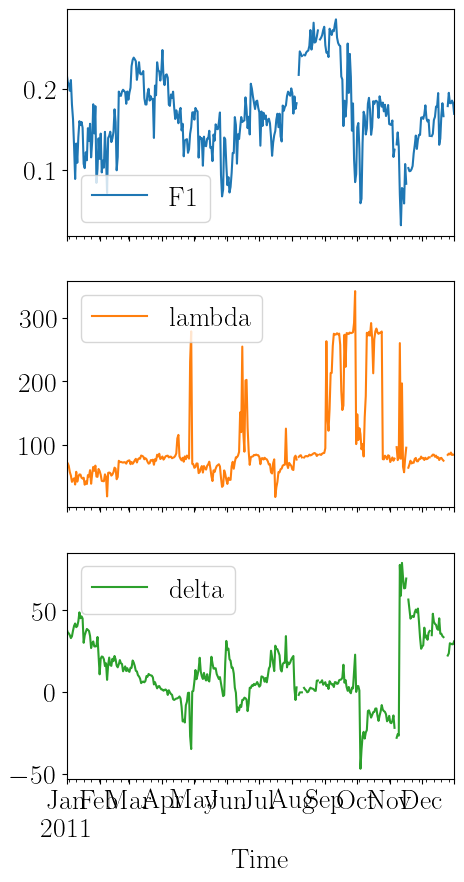

In [8]:
voyager1_data_daily[["F1", "lambda", "delta"]].plot(subplots=True, figsize=(5, 10))

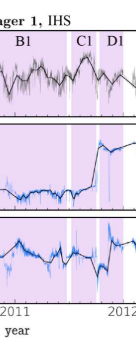

Looks fine, apart from lambda.

Proceeding to extract interval D1 (we won't be using lambda)

In [9]:
# Get DOY 276-365 from the raw data
subset = voyager1_data["2011-10-03":"2011-12-31"]
del voyager1_data
del voyager1_data_daily
print(len(subset))

160587


In [10]:
subset.isna().sum() / len(subset)

F1        0.798315
BR        0.798315
BT        0.798315
BN        0.798315
lambda    0.798315
delta     0.798315
dtype: float64

80% data missing

### Reproducing full SFs

In [11]:
subset_resampled = subset.resample("10min").mean()  # Now only 12,000 long
len(subset_resampled)

12847

In [12]:
# Takes about 30 seconds

sf = utils.calc_struct_sdk(
    data=subset_resampled["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)


In [13]:
subset_lint = subset_resampled.interpolate(method="linear")

sf_lint = utils.calc_struct_sdk(
    data=subset_lint["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)

Implementing Frat's statistical sigificance threshold

In [14]:
# Define the window size for 48 hours in seconds
# Convert index to time index
sf.index = pd.to_timedelta(sf.index, unit="s")

window_size = pd.to_timedelta("48H")

# Compute the rolling maximum for a 48-hour window
sf["rolling_max"] = (
    sf["N"].rolling(window=window_size, min_periods=1, center=True).max()
)

# Compute the threshold
sf["threshold"] = 0.25 * sf["rolling_max"]

# Determine the color based on the threshold
sf["color"] = np.where(sf["N"] < sf["threshold"], "gray", "black")

# Convert the time index to back to seconds
sf.index = sf.index.total_seconds()


### Computing standard SF

Calculating correlation time, using full 60-day dataset

In [27]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [subset.BR, subset.BT, subset.BN],
    nlags=20000,
    plot=True,
)

tc_exp = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)
print(f"Correlation time = {np.round(tc_exp)}s = {np.round(tc_exp/3600)} hours")


NameError: name 'subset' is not defined

Note highly wiggly ACF due to gaps. Also calculating $\lambda_C$ using integral method

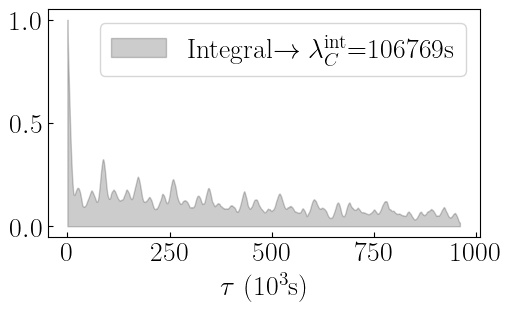

29.658154039051336
hours


In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
tc, fig, ax = utils.compute_outer_scale_integral(time_lags_lr, r_vec_lr, fig, ax, True)
# print(f"Correlation time = {np.round(tc)}s = {np.round(tc/3600)} hours")

plt.show()
print(tc / 60 / 60)
print("hours")

In [17]:
print(
    "10 of these is ",
    10 * tc / 60 / 60,
    "days, compared with full data length of",
    subset.index[-1] - subset.index[0],
)

10 of these is  296.5815403905134 days, compared with full data length of 89 days 05:08:48


This version is much longer (which will make things easier for standardising the interval - but is it accurate?)

In [18]:
tc_n = 10
interval_length = params.int_length
new_cadence = tc_n * tc / interval_length

lags = np.arange(1, params.max_lag_prop * params.int_length)
powers = [2]

In [19]:
subset_std = subset.resample(str(np.round(new_cadence), 3) + "S").mean()
int_std = subset_std[:10000]

In [23]:
del subset, subset_lint

In [58]:
int_norm = utils.normalize(int_std)
bad_input = int_norm[["BR", "BT", "BN"]]

c:\Users\spann\Documents\Research\Code repos\sf_gap_analysis\venv\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [112]:
print(bad_input.isna().sum() / len(bad_input["BR"]))

BR    0.6598
BT    0.6598
BN    0.6598
dtype: float64


In [114]:
bad_output = sf.compute_sf(bad_input, lags, powers, False, False)
bad_output["gap_handling"] = "naive"
bad_output["file_index"] = 0
bad_output["int_index"] = 0
bad_output["version"] = 0

In [115]:
interp_input = (
    bad_input.interpolate(method="linear").ffill().bfill()
)  # Linearly interpolate (and, in case of missing values at edges, back and forward fill)
interp_output = sf.compute_sf(interp_input, lags, powers, False, False)

In [116]:
interp_input_df = pd.DataFrame(interp_input)
interp_input_df.reset_index(inplace=True)  # Make time a column, not an index

interp_output["file_index"] = 0
interp_output["int_index"] = 0
interp_output["version"] = 0
interp_output["gap_handling"] = "lint"

# Correcting sample size and uncertainty for linear interpolation, same values as no handling
interp_output["n"] = bad_output["n"]
interp_output["missing_percent"] = bad_output["missing_percent"]
interp_output["sf_2_se"] = bad_output["sf_2_se"]

In [117]:
n_bins = 25
output_path = "final"
import pickle

sfs_gapped = pd.concat([interp_output, bad_output])


In [118]:
# Importing lookup table
with open(
    f"data/corrections/{output_path}/correction_lookup_2d_{n_bins}_bins.pkl", "rb"
) as f:
    correction_lookup_2d = pickle.load(f)
with open(
    f"data/corrections/{output_path}/correction_lookup_3d_{n_bins}_bins.pkl", "rb"
) as f:
    correction_lookup_3d = pickle.load(f)

# Apply 2D and 3D scaling to test set, report avg errors

sfs_lint_corrected_2d = sf.compute_scaling(sfs_gapped, 2, correction_lookup_2d, n_bins)

sfs_lint_corrected_2d_3d = sf.compute_scaling(
    sfs_lint_corrected_2d, 3, correction_lookup_3d, n_bins
)

correction_wide = sfs_lint_corrected_2d_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_corrected_2d",
        "sf_2_corrected_3d",
    ]
]
correction_long = pd.wide_to_long(
    correction_wide,
    ["sf_2"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)
correction_bounds_wide = sfs_lint_corrected_2d_3d[
    [
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "sf_2_lower_corrected_2d",
        "sf_2_lower_corrected_3d",
        "sf_2_upper_corrected_2d",
        "sf_2_upper_corrected_3d",
    ]
]

correction_bounds_long = pd.wide_to_long(
    correction_bounds_wide,
    ["sf_2_lower", "sf_2_upper"],
    i=["file_index", "int_index", "version", "lag", "missing_percent"],
    j="gap_handling",
    sep="_",
    suffix=r"\w+",
)

corrections_long = pd.merge(
    correction_long,
    correction_bounds_long,
    how="inner",
    on=[
        "file_index",
        "int_index",
        "version",
        "lag",
        "missing_percent",
        "gap_handling",
    ],
).reset_index()

# Adding the corrections, now as a form of "gap_handling", back to the gapped SF dataframe
sfs_gapped_corrected = pd.concat([sfs_gapped, corrections_long])

Loaded 2D lookup table with 25 bins
Loaded 3D lookup table with 25 bins


In [119]:
sfs_gapped_corrected

,lag,n,missing_percent,sf_2,sf_2_se,file_index,int_index,version,gap_handling,sf_2_lower,sf_2_upper
1.0,1.0,3364.0,66.356636,0.022850,0.001179,0,0,0,lint,NaN,NaN
2.0,2.0,3346.0,66.533307,0.037878,0.002208,0,0,0,lint,NaN,NaN
3.0,3.0,3328.0,66.710013,0.050765,0.003050,0,0,0,lint,NaN,NaN
4.0,4.0,3304.0,66.946779,0.060045,0.003746,0,0,0,lint,NaN,NaN
5.0,5.0,3282.0,67.163582,0.065160,0.004341,0,0,0,lint,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3993.0,1997.0,NaN,91.078346,4.921236,NaN,0,0,0,corrected_3d,4.218981,5.903959
3994.0,1998.0,NaN,91.064734,4.641876,NaN,0,0,0,corrected_2d,3.750759,6.088369
3995.0,1998.0,NaN,91.064734,4.923272,NaN,0,0,0,corrected_3d,4.220726,5.906401
3996.0,1999.0,NaN,91.063617,4.644204,NaN,0,0,0,corrected_2d,3.752641,6.091423


Ad-hoc plot, before full consistent version after

**NOW, add in bad version, plot nicely, add some metadata, slopes**

**THEN, look into smoothing**

[]

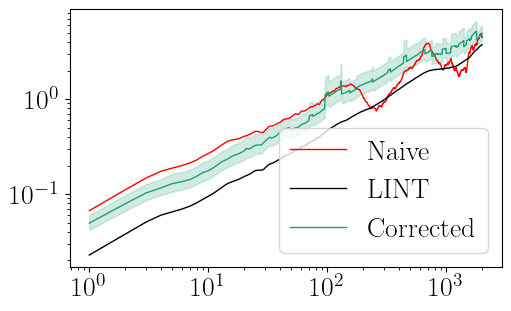

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

file_index = 0
int_index = 0
version = 0

ax[1].plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "lag",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "naive"),
        "sf_2",
    ],
    color="red",
    lw=1,
    label="Naive",
)
ax[1].plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "lag",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "lint"),
        "sf_2",
    ],
    color="black",
    lw=1,
    label="LINT",
)

# ax[1].plot(
#     sfs_gapped_corrected.loc[
#         (sfs_gapped_corrected["file_index"] == file_index)
#         & (sfs_gapped_corrected["int_index"] == int_index)
#         & (sfs_gapped_corrected["version"] == version)
#         & (sfs_gapped_corrected["gap_handling"] == "corrected_2d"),
#         "lag",
#     ],
#     sfs_gapped_corrected.loc[
#         (sfs_gapped_corrected["file_index"] == file_index)
#         & (sfs_gapped_corrected["int_index"] == int_index)
#         & (sfs_gapped_corrected["version"] == version)
#         & (sfs_gapped_corrected["gap_handling"] == "corrected_2d"),
#         "sf_2",
#     ],
#     color="blue",
#     lw=1,
#     label="Corrected (2D) ({:.1f})".format(
#         ints_gapped_metadata.loc[
#             (ints_gapped_metadata["file_index"] == file_index)
#             & (ints_gapped_metadata["int_index"] == int_index)
#             & (ints_gapped_metadata["version"] == version)
#             & (ints_gapped_metadata["gap_handling"] == "corrected_2d"),
#             "mape",
#         ].values[0]
#     ),
# )
ax[1].plot(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2",
    ],
    color="#1b9e77",
    lw=1,
    label="Corrected",
)
ax[1].fill_between(
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "lag",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_lower",
    ],
    sfs_gapped_corrected.loc[
        (sfs_gapped_corrected["file_index"] == file_index)
        & (sfs_gapped_corrected["int_index"] == int_index)
        & (sfs_gapped_corrected["version"] == version)
        & (sfs_gapped_corrected["gap_handling"] == "corrected_3d"),
        "sf_2_upper",
    ],
    color="#1b9e77",
    alpha=0.2,
)

ax[1].legend(loc="lower right")
ax[1].semilogx()
ax[1].semilogy()


### Big figure reproduction

Text(24000.0, 5e-08, '12h')

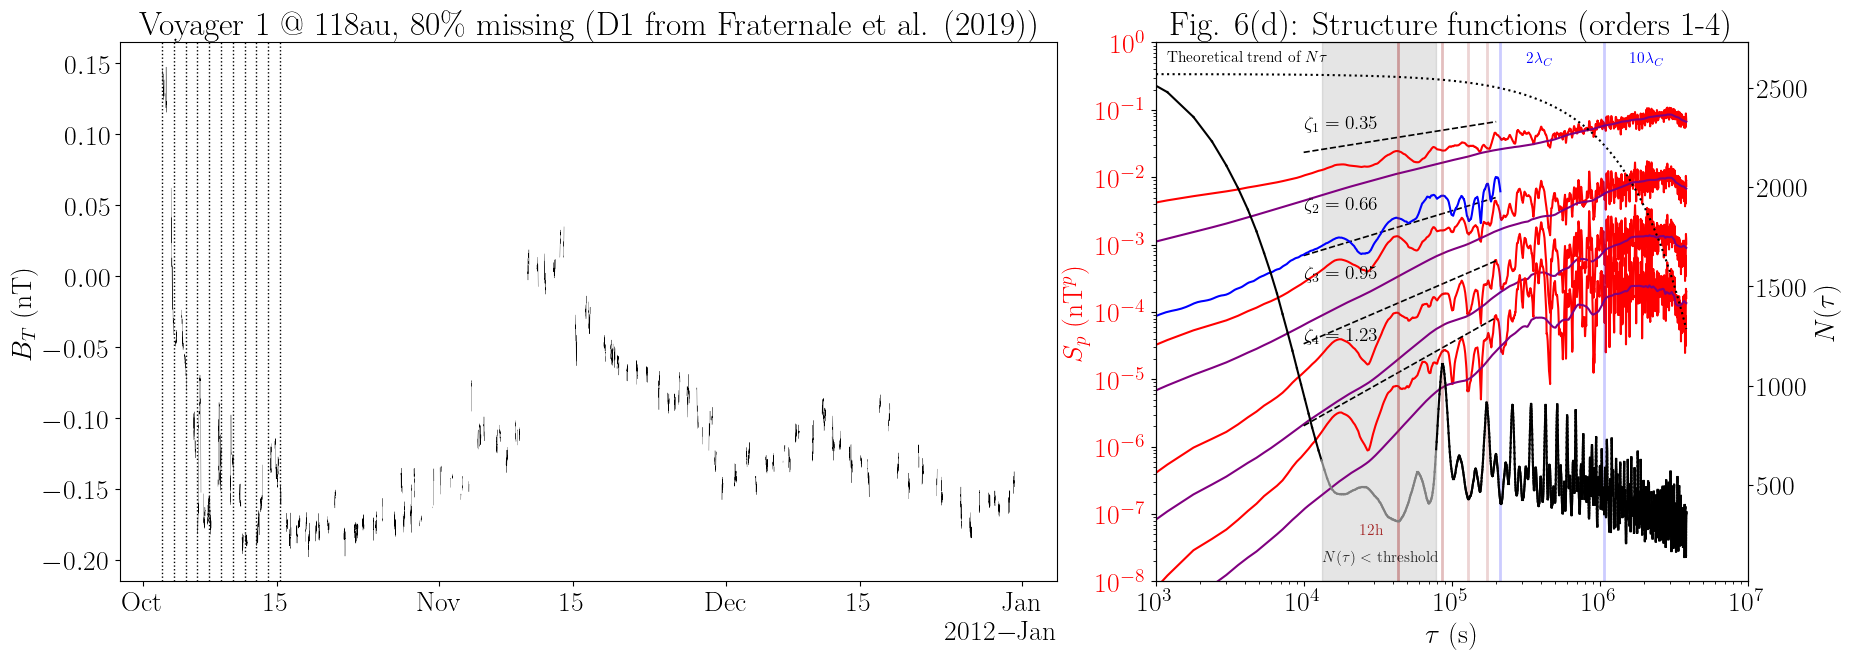

In [24]:
# Plot structure functions
xlim = (1e3, 1e7)
ylim_sf = (1e-8, 1e0)
ylim_kurt = (2, 10)

# sdk = sf[[2, 4]].copy()
# sdk["kurtosis"] = sdk[4].div(sdk[2] ** 2)


fig = plt.figure(figsize=(21, 7))
gs = gridspec.GridSpec(1, 5, wspace=0.4)
ax0 = plt.subplot(gs[0, 0:3])

ax1 = plt.subplot(gs[0, 3:])

ax0.plot(subset_resampled.BT, c="black", lw=0.2)
for i in range(11):
    ax0.axvline(
        subset_resampled.index[0] + pd.Timedelta(tc * i, "s"),
        color="black",
        linestyle="dotted",
        lw=1,
    )
ax0.set_title(r"Voyager 1 @ 118au, 80\% missing (D1 from Fraternale et al. (2019))")
ax0.set_ylabel("$B_T$ (nT)")
ax0.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax0.xaxis.get_major_locator())
)

for p in [1, 2, 3, 4]:
    ax1.plot(sf.index, sf[p], c="red", label=f"p={p}")
    qi, xi, pi = utils.fitpowerlaw(sf.index, sf[p].values, 1e4, 2e5)
    ax1.plot(
        xi,
        pi * 2,
        c="black",
        ls="--",
        lw=1.2,
        label="Inertial range power-law fit: $\\alpha_i$ = {0:.2f}".format(qi[0]),
    )

    # Add the slope value as an annotation based on location of the fit
    plt.annotate(
        "$\\zeta_{0} = {1:.2f}$".format(p, qi[0]),
        (xi[0], np.median(pi) * 2),
        fontsize=14,
    )

    ax1.plot(sf_lint.index, sf_lint[p], c="purple", label=f"p={p}")

ax1.plot(sf_std.index, sf_std[2], c="blue", label="10 lambda C")
ax1.semilogx()
ax1.semilogy()
ax1.set(title="Fig. 6(d): Structure functions (orders 1-4)", xlabel="Lag (s)")
if xlim is not None:
    ax1.set_xlim(xlim)
if ylim_sf is not None:
    ax1.set_ylim(ylim_sf)

# plt.show()

ax1.set_xlabel("$\\tau$ (s)")
ax1.set_ylabel("$S_p$ (nT$^p$)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

rectangle_x = sf[sf.color == "gray"].index[0]
rectangle_width = sf[sf.color == "gray"].index[-1] - sf[sf.color == "gray"].index[0]

# Add rectangle to show the range of the power-law fit
ax1.add_patch(
    plt.Rectangle(
        (rectangle_x, 1e-8),
        rectangle_width,
        1,
        color="black",
        alpha=0.1,
    ),
)

ax2 = ax1.twinx()
plt.plot(
    sf.index,
    0.2 * (len(subset_resampled) - (sf.index / 600)),
    color="black",
    ls="dotted",
    label="Theoretical sample size",
)
for i in range(len(sf) - 1):
    ax2.plot(
        sf.index[i : i + 2],
        sf["N"].values[i : i + 2],
        color=sf["color"].values[i],
    )
ax2.set_ylabel("$N(\\tau)$", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax1.text(rectangle_x, 2e-8, "$N(\\tau)<$ threshold", fontsize=11, alpha=0.8)
ax1.text(1.2e3, 5e-1, "Theoretical trend of $N\\tau$", fontsize=11)
# Add vertical line at lag equal to 8 correlation times
ax1.axvline(x=10 * tc, c="blue", lw=2, alpha=0.2)
ax1.axvline(x=2 * tc, c="blue", lw=2, alpha=0.2)
# ax1.axvline(x=48 * 3600, c="purple", lw=2, alpha=0.2)
ax1.axvline(x=12 * 3600, c="brown", lw=2, alpha=0.4)
ax1.axvline(x=24 * 3600, c="brown", lw=2, alpha=0.3)
ax1.axvline(x=36 * 3600, c="brown", lw=2, alpha=0.2)
ax1.axvline(x=48 * 3600, c="brown", lw=2, alpha=0.2)

ax1.text(10 * tc * 1.5, 5e-1, "$10\\lambda_C$", fontsize=11, c="blue")
ax1.text(2 * tc * 1.5, 5e-1, "$2\\lambda_C$", fontsize=11, c="blue")

# ax1.text(48 * 3600 * 1.2, 5e-1, "Burger max lag", fontsize=11, c="purple")
ax1.text(12 * 3600 / 1.8, 5e-8, "12h", fontsize=11, c="brown")

# plt.savefig("plots/background/voyager_sf.png")


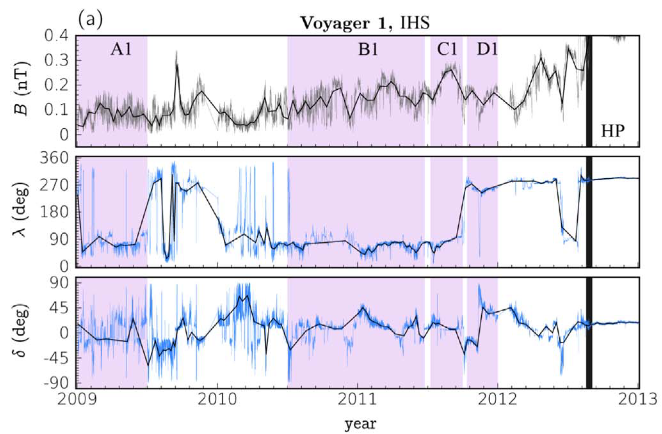  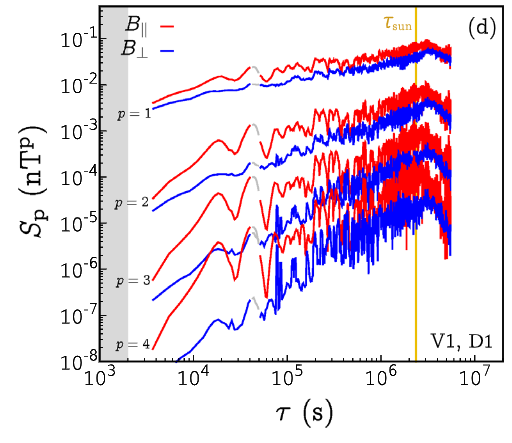 



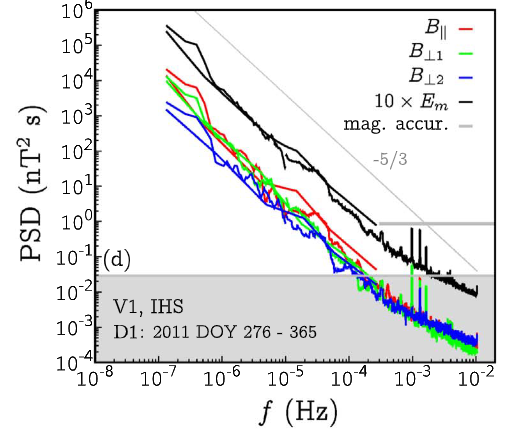



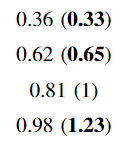

**Thresholding procedure**
"the computation of $S$ is nontrivial for Voyager data sets due to the amount and distribution of missing data." They do not interpolate, but they do account for the variable reduction in sample size at each lag by applying a threshold of statistical significance as to whether they use certain lags to calculate the slopes

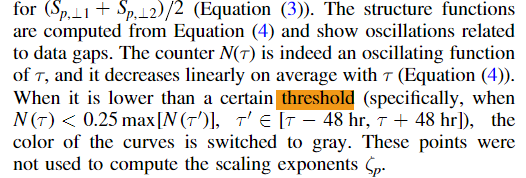

Interestingly, the slopes $\zeta_p$ from my re-sample are closer to the theoretical ESS values!

Focussing on second-order SF ($p=2$). Let's standardise the interval according to my procedure, wanting 8 corr lengths.

Dominant gap periodicity found to be 43,000s = 12h (typicaly daily telemetry gap of 8-16hr: lines up with major trough in $N(\tau)$): minima occur at multiples of this frequency

A spectral break was not identified in the (corrected) spectra for this interval, but elsewhere it was found to be at about 1-2e-5

- Increase # corr lengths used in standardisation
- Decrease interval length
- Settle with interval size that won't allow us to directly compare with these results

See Fig. 5(d) below for the power spectrum and metadata. Note that this power spectra was built using the technique they developed of compressed sensing, as well as linear interpolation + BT-method for $f<10^{-5}$


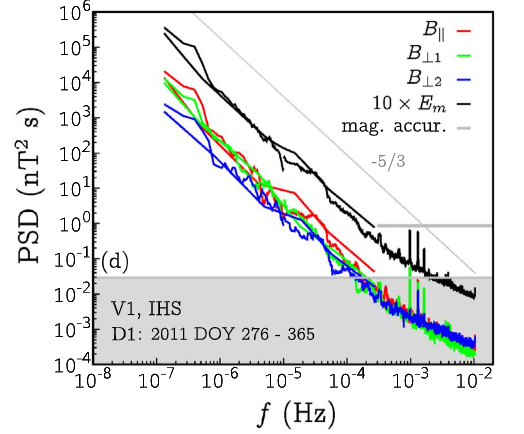

The correlation length is about 2 hours. I have been standardising my intervals to have 8 correlation lengths: they have 800. 8 correlation lengths only just gets us to the start of the range over which they perform they power-law fit. We would need about 20 to cover that full range.

Correlation timescale is about 2 and half hours. An interval of 3500 and 20 timescales would match the resolution: larger interval or fewer timescales would not work, would have to increase or decrease both.

---